C:\Users\USER\AppData\Local\Temp\ipykernel_11980\627078066.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.52      0.29      0.37        49
           1       0.52      0.75      0.61        51

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.49       100
weighted avg       0.52      0.52      0.49       100



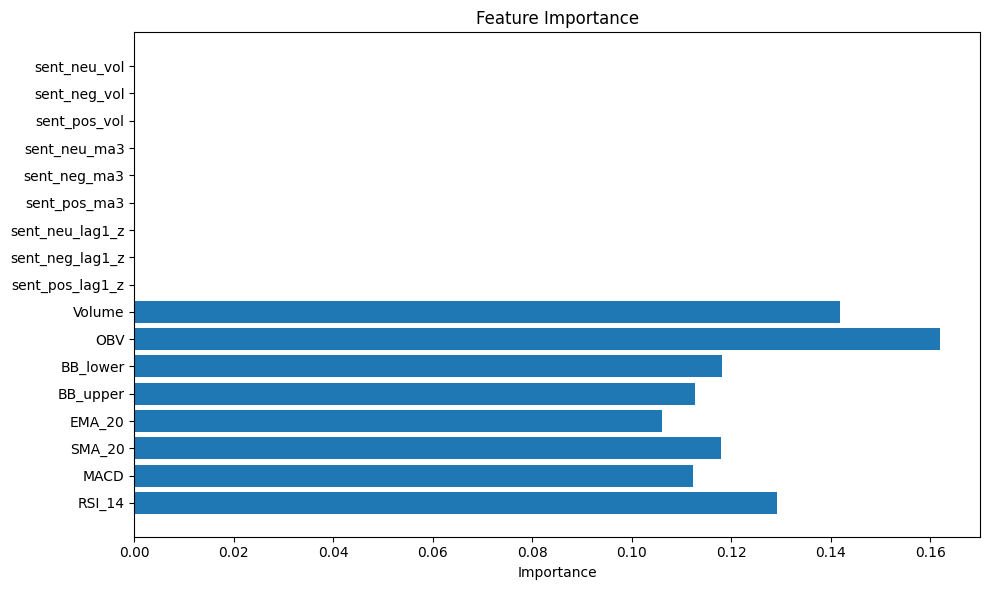

In [ ]:
import pandas as pd
import numpy as np
from binance.client import Client
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. Load Price Data
client = Client()
klines = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY, limit=500)
df = pd.DataFrame(klines, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
                                  'Quote volume', 'Trades', 'Taker buy volume', 'Taker quote volume', 'Ignore'])
df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# 2. Technical Indicators
def add_indicators(df):
    df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    return df

df = add_indicators(df)

# 3. Load & Process Sentiment
sentiment_df = pd.read_csv('news_with_sentiment.csv')

# Ensure column names are consistent
# (news_with_sentiment.csv uses 'sent_neutral', so rename → 'sent_neu')
sentiment_df = sentiment_df.rename(columns={'sent_neutral': 'sent_neu'})

# Convert publishedAt → timezone-naive date
sentiment_df['Date'] = pd.to_datetime(
    sentiment_df['publishedAt'], errors='coerce'
).dt.tz_localize(None)

# Keep only the sentiment columns we need
sent_cols = ['sent_pos', 'sent_neg', 'sent_neu']
daily_sentiment = (
    sentiment_df
    .groupby('Date')[sent_cols]          # average scores per day
    .mean()
    .reset_index()
)

# Add lags, 3-day moving averages, and z-scores
for col in sent_cols:
    daily_sentiment[f'{col}_lag1'] = daily_sentiment[col].shift(2    )
    daily_sentiment[f'{col}_ma3']  = daily_sentiment[col].rolling(3).mean()

# Z-score normalisation of lag-1 columns
for col in [f'{c}_lag1' for c in sent_cols]:
    mean, std = daily_sentiment[col].mean(), daily_sentiment[col].std()
    daily_sentiment[f'{col}_z'] = (daily_sentiment[col] - mean) / std

# Merge with price data
df['Date'] = df['Date'].dt.tz_localize(None)
df = pd.merge(df, daily_sentiment, on='Date', how='left')

# Fill NaNs
df.fillna(method='ffill', inplace=True)
df.fillna(0, inplace=True)

# 4. Add Interaction Terms (sentiment × volume)
df['sent_pos_vol'] = df['sent_pos_lag1'] * df['Volume']
df['sent_neg_vol'] = df['sent_neg_lag1'] * df['Volume']
df['sent_neu_vol'] = df['sent_neu_lag1'] * df['Volume']

# 5. Define Target
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# 6. Feature Set
features = [
    'RSI_14', 'MACD', 'SMA_20', 'EMA_20',
    'BB_upper', 'BB_lower', 'OBV', 'Volume',
    'sent_pos_lag1_z', 'sent_neg_lag1_z', 'sent_neu_lag1_z',
    'sent_pos_ma3', 'sent_neg_ma3', 'sent_neu_ma3',
    'sent_pos_vol', 'sent_neg_vol', 'sent_neu_vol'
]

X = df[features].dropna()
y = df.loc[X.index, 'Target']

# 7. Time-Based Train/Test Split
split_date = df['Date'].quantile(0.8)
X_train = X[df['Date'] < split_date]
y_train = y[df['Date'] < split_date]
X_test = X[df['Date'] >= split_date]
y_test = y[df['Date'] >= split_date]

# 8. Train Model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# 9. Evaluation
y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# 10. Feature Importance Plot
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [3]:
print(X_train.columns.tolist())

['RSI_14', 'MACD', 'SMA_20', 'EMA_20', 'BB_upper', 'BB_lower', 'OBV', 'Volume', 'sent_pos_lag1_z', 'sent_neg_lag1_z', 'sent_neu_lag1_z', 'sent_pos_ma3', 'sent_neg_ma3', 'sent_neu_ma3', 'sent_pos_vol', 'sent_neg_vol', 'sent_neu_vol']
